# Pentagon Testing procedure.
Pells the files from the directory of MMSE scanned documets that were classified as writing pages.
The method first finds all the contours on the page and uses a pentagon detection algorythm to find what parameters define as a drawn pentagon. 
Once pentagon is found methods are use to output the corner bitmap coordinates
Those conreres then can be analyzed... placing lines connected and other methods to get whole shape and info of pentagon.

In [260]:
# Import the required modules
from skimage.io import imread
from skimage.feature import hog
from sklearn.externals import joblib
import cv2, os, time, math, itertools, random, xlwt
import numpy as np
from line_equations import Line
import matplotlib.pyplot as plt
from skimage import img_as_ubyte
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## Walk the path and pull a random MMSE scanned page
Print filename and show image

07265221  Baseline  04-08-02img-8.png


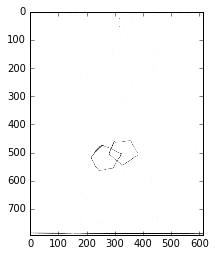

In [261]:
%matplotlib inline
home_path = r'C:\Users\KinectProcessing\Desktop'
path = r'C:\Users\KinectProcessing\Desktop\training_mmse_pentagons'
model_path =  os.path.join(path, "models", "svm.model")
testing_path = r'C:\Users\KinectProcessing\Desktop\test_mmse_classify\extracted_images\mmse_data'
file = random.choice([x for x in os.listdir(testing_path) if os.path.isfile(os.path.join(testing_path, x))])
print(file)
test_file = os.path.join(testing_path, file)
im = cv2.imread(test_file, cv2.IMREAD_GRAYSCALE)
plt.imshow(im,cmap='gray')
plt.show()

## Find the all the contours in the image using the cv2.find contours method
http://docs.opencv.org/trunk/d3/dc0/group__imgproc__shape.html#ga17ed9f5d79ae97bd4c7cf18403e1689a

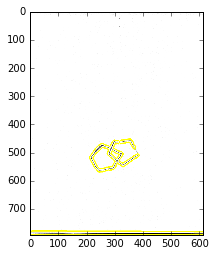

In [262]:
clone = im.copy() #clone image
color_im = cv2.cvtColor(clone,cv2.COLOR_GRAY2BGR) 
#preprocessing of image applying gaussianblur and thresholding OTSU
blur = cv2.GaussianBlur(clone,(5,5),0) 
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

#preprocessing of image applying canny edge detection and dialtion to get all contours
edges = cv2.Canny(th3,0,255,apertureSize = 3) # Canny image 
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3)) # create the kernle
edges = cv2.dilate(edges, kernel, iterations=5)

im2, contours, hierarchy = cv2.findContours(edges,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE) # find each contour
cv2.drawContours(color_im, contours, -1, (255,255,0), 3) #draw all contours

plt.imshow(color_im, cmap='gray')
plt.show()

## Bound the contours in rectangles

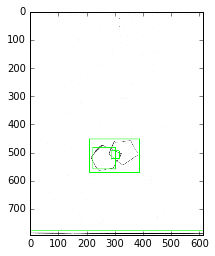

In [263]:
img = cv2.cvtColor(clone,cv2.COLOR_GRAY2BGR) 

for cnt in contours:
        # get the perimeter circularity of the contours
        hull = cv2.convexHull(cnt)
        area = cv2.contourArea(hull)
        perimeter = cv2.arcLength(hull,True)
        approx = cv2.approxPolyDP(cnt,0.01*cv2.arcLength(cnt,True),True)
        #cv2.drawContours(clone, cnt, -1, (0,255,255), 3)
        if perimeter != 0:
            x,y,w,h = cv2.boundingRect(cnt)
            cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)   
#img = cv2.cvtColor(clone, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

## Detection method of detecting a correct pentagon.
Uses the HOG (Histogram Oriented Gradients) algorythm
https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients

In [264]:
def detection(img):
    '''
    The detections methond using the HOG algorithm
    '''
    clf = joblib.load(model_path) #prediciton method using SVM
    kernel = np.ones((5,5),np.uint8)
    opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    im_reshape = cv2.resize(opening, (128,128)) # reduces noise on image
    fd, _ = hog(im_reshape,9, (8,8), (3,3), visualise = True, transform_sqrt=True)           
    pred = clf.predict(fd)
    print(pred)
    print(clf.decision_function(fd))
    if pred == 1:
        return clf.decision_function(fd)
    else:
        return 0
    


## Method for finding detection used on found contours
Set the threshold and place RED bounding boxes around accepted detections

c:\users\kinectprocessing\appdata\local\programs\python\python35\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


[0]
[-1.54093244]
detection 0 777 0
[1]
[ 1.10731948]
detection 210 452 [ 1.10731948]
[1]
[ 0.29255879]
detection 286 494 [ 0.29255879]
[0]
[-0.62001995]
detection 222 481 0


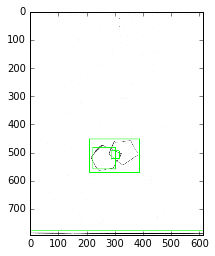

In [265]:

detection_threshold = 1.4 # change this to change accepted detection High is above 1.5... Low is 0.5

img = cv2.cvtColor(clone,cv2.COLOR_GRAY2BGR) 

for cnt in contours:
        # get the perimeter circularity of the contours
        hull = cv2.convexHull(cnt)
        area = cv2.contourArea(hull)
        perimeter = cv2.arcLength(hull,True)
        approx = cv2.approxPolyDP(cnt,0.01*cv2.arcLength(cnt,True),True)
        #cv2.drawContours(clone, cnt, -1, (0,255,255), 3)
        if perimeter != 0:
            x,y,w,h = cv2.boundingRect(cnt)
            cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
            if (h*w) > 200: # minimum area of the contour bounding box
                feature = clone[y:y + h, x:x + w]
                cd = detection(feature)
                print('detection', x,y, cd)
                if (cd > detection_threshold): #threshold for acceptance for HOG
                    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
#img = cv2.cvtColor(clone, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()